# Modelling and Validating a Random Forest model

I prepare and simplify the data so that it can be easily fit to a Random Forest Classification model.I find the best parameters for the model by means of hyperparameter tuning. I check for performance metrics like accuracy and ROC score. I check the learning curve to understand which train-test-validation split is most appropriate for the data at hand. Lastly, I predict new observations and consider whether the predictions make sense.

0. Import Libraries and do general settings

In [25]:
!pip install scikit-learn

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, ShuffleSplit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [4]:
df = pd.read_excel(r"C:\Users\felis\Github_DataScience\BMW_Portfolio\creditscoring.xlsx")

1. Prepare Dataset

1.1. Handle missing values

In [7]:
df.isnull().sum()

nolatepayment          400
timelatepayment        400
lengthcredithistory      0
creditmix                0
newcredit                0
amountsowned             0
sum_all_columns          0
paymenthistory         600
scaled_scores            0
dtype: int64

Most Machine Learning Algorithms can't handle missing values. Also, there is no way to impute the data without distorting the model. Therefore, I condense the columns 'nolatepayment', 'timelatepayment' and 'paymenthistory' to a binary category column 'paymenthistory'. 1 will equal to the missing values in the current column 'payment history' which refers to the fact that the person has not paid its bills on time. 0 will equal to the existing values in the current column 'payment history' which refers to the fact that person has paid its bills on time.

In [8]:
df.loc[df['paymenthistory'] == -0.35, 'paymenthistory'] = 0

In [9]:
df.loc[df['paymenthistory'] != 0, 'paymenthistory'] = 1

In [10]:
df["paymenthistory"].value_counts()

paymenthistory
1.0    600
0.0    400
Name: count, dtype: int64

In [11]:
df.drop(columns = ["nolatepayment", "timelatepayment"], axis = 1, inplace = True)

In [13]:
df = df.reindex(columns=["lengthcredithistory",
                        "creditmix",
                        "newcredit",
                        "amountsowned",
                        "paymenthistory",
                        "sum_all_columns",
                        "scaled_scores"])

1.2. Create a classification target variable

https://www.investopedia.com/terms/c/credit_score.asp

Here are the general ranges for how credit scores are categorized.4

    Excellent: 800–850
    Very Good: 740–799
    Good: 670–739
    Fair: 580–669
    Poor: 300–579

In [14]:
# I set the highest three scores to class 0 to make the target column less imbalanced
# So basically the new categories are equivalent to poor, fair and good / very good / excellent
df["rating"] = None

for index, score in df["scaled_scores"].items():
    if 299 < score < 580:
        df.loc[index, "rating"] = 2
    elif 580 <= score < 670:
        df.loc[index, "rating"] = 1
    elif 670 <= score < 740:
        df.loc[index, "rating"] = 0
    elif 740 <= score < 800:
        df.loc[index, "rating"] = 0
    elif 800 <= score <= 850:
        df.loc[index, "rating"] = 0

In [15]:
df["rating"].isnull().sum()

0

In [64]:
# The dataset is still imbalanced, but the number of observations in class 0 is not as low as if I had created 5 classes
df["rating"].value_counts()

rating
2    593
1    281
0    126
Name: count, dtype: int64

In [16]:
df.drop(columns = "scaled_scores", axis = 1, inplace = True)

In [17]:
df.drop(columns = "sum_all_columns", axis = 1, inplace = True)

1.3. Train Test Validation Split

In [18]:
df.head(3)

,lengthcredithistory,creditmix,newcredit,amountsowned,paymenthistory,rating
0,-0.172063,0.15,0.1,0.064414,1.0,1
1,-0.300000,-0.15,0.1,-0.100000,1.0,2
2,-0.110426,0.15,0.1,0.073960,1.0,0


In [19]:
X = df.iloc[:,0:5]

In [20]:
X.shape

(1000, 5)

In [21]:
y = df["rating"]

In [22]:
y.shape

(1000,)

In [27]:
# Split the data into train and temp sets (90% train, 10% test)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=12)
# Further split the temp set into train and validation sets (80% train, 10% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.111, stratify=y_train_temp, random_state = 12)

In [28]:
y_train.shape

(800,)

In [29]:
y_test.shape

(100,)

In [30]:
y_val.shape

(100,)

In [31]:
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
y_val = y_val.astype('int64')

3. Model Implementation: Random Forest

For illustrative purposes, I only run a RandomForest algorithm. 
The Random Forest Classifier is an ensemble learning method used for classification tasks in machine learning. It builds multiple decision trees by randomly selecting subsets of the data and features. The final prediction is determined by the majority vote of the individual decision trees, making the model more accurate, robust, and less prone to overfitting.

3.1. Hyperparameter Tuning

I define a parameter grid containing various hyperparameters for the RandomForestClassifier that I want to tune.

Next, I create a RandomForestClassifier instance and perform GridSearchCV with 5-fold cross-validation (cv=5). The scoring metric used is the ROC AUC score (scoring='roc_auc'). GridSearchCV will try all combinations of hyperparameters and evaluate their performance on the test and validation set.

In [32]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [10, 25, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10], 
    'class_weight' : ['balanced', None]
}

# Create the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=12)

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the final model with the best hyperparameters on the combined train-validation set
best_rf_clf = RandomForestClassifier(random_state=42, **best_params)
best_rf_clf.fit(X_val, y_val)

# Evaluate on the test set
y_pred_test = best_rf_clf.predict_proba(X_test)
test_roc_auc = roc_auc_score(y_test, y_pred_test, multi_class='ovo')

# Evaluate on the validation set
y_pred_val = best_rf_clf.predict_proba(X_val)
val_roc_auc = roc_auc_score(y_val, y_pred_val, multi_class='ovo')

print("Best Hyperparameters:", best_params)
print("Test ROC AUC Score:", test_roc_auc)
print("Validation ROC AUC Score:", val_roc_auc)

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partit

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}
Test ROC AUC Score: 0.9079127087601665
Validation ROC AUC Score: 0.9972527472527473


C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan

3.2. Fit a Model

The parameters of the best fit are: 'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10.

Therefore, I fit a corresponding model and compute its accuracy and ROC score. Note that the ROC score is the metric that I base my decisions on, in particular cause it is suited better for imbalanced datasets. Nonetheless, accuracy is good for getting a first idea of the model performance.

In [33]:
# balanced class weights handle with imbalanced datasets better
model = RandomForestClassifier(random_state=12, class_weight = 'balanced', max_depth = None, min_samples_split = 2, n_estimators = 10)

In [34]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=10,
                       random_state=12)

In [35]:
y_pred_train_proba = model.predict_proba(X_train)

In [36]:
y_pred_train = model.predict(X_train)

In [37]:
accuracy_score_train = accuracy_score(y_train, y_pred_train)
accuracy_score_train

0.995

In [38]:
cm_train = confusion_matrix(y_train, y_pred_train)

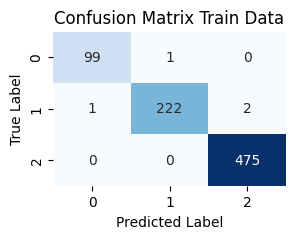

In [40]:
plt.figure(figsize=(3, 2))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix Train Data')
plt.show()

In [41]:
roc_score_train = roc_auc_score(y_train, y_pred_train_proba, multi_class='ovo')
roc_score_train

0.9999189083820662

4. Model Validation

4.1. Model performance of the test and validation dataset

In [42]:
# Predict probabilities for test data
y_pred_test_proba = model.predict_proba(X_test)

In [43]:
y_pred_test = model.predict(X_test)

In [44]:
accuracy_score_test = accuracy_score(y_test, y_pred_test)
accuracy_score_test

0.88

In [45]:
cm_test = confusion_matrix(y_test, y_pred_test)

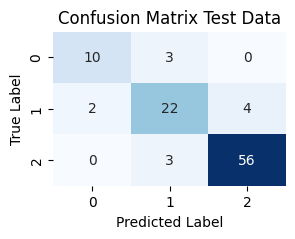

In [46]:
plt.figure(figsize=(3, 2))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix Test Data')
plt.show()

In [47]:
roc_score_test = roc_auc_score(y_test, y_pred_test_proba, multi_class='ovo')
roc_score_test

0.9505688520519029

In [48]:
# Predict probabilities for validation data
y_pred_val_proba = model.predict_proba(X_val)

In [49]:
y_pred_val = model.predict(X_val)

In [50]:
accuracy_score_val = accuracy_score(y_val, y_pred_val)
accuracy_score_val

0.91

In [51]:
cm_val = confusion_matrix(y_val, y_pred_val)

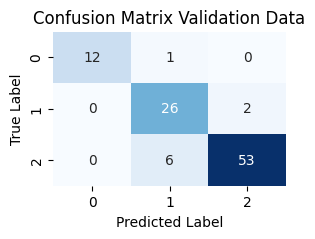

In [52]:
plt.figure(figsize=(3, 2))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix Validation Data')
plt.show()

In [53]:
roc_score_val = roc_auc_score(y_val, y_pred_val_proba, multi_class='ovo')
roc_score_val

0.9847038554665674

In [54]:
modelperformance = {"Accuracy": [accuracy_score_train, accuracy_score_test, accuracy_score_val], 
                         "ROC Score": [roc_score_train, roc_score_test, roc_score_val]}

In [55]:
modelperformance = pd.DataFrame(modelperformance)

In [56]:
modelperformance.rename(index={0: "Train", 1: "Test", 2: "Validation"}, inplace=True)


In [57]:
modelperformance

,Accuracy,ROC Score
Train,0.995,0.999919
Test,0.880,0.950569
Validation,0.910,0.984704


4.2. Learning Curves

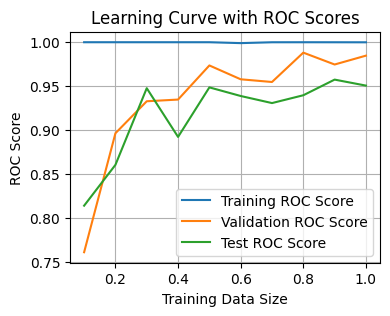

In [58]:
# Create empty lists to store ROC scores for the training, validation, and test sets
roc_scores_train = []
roc_scores_val = []
roc_scores_test = []

# Define different sizes of training data to use in the learning curve
training_sizes = np.linspace(0.1, 1.0, 10, endpoint=True)

# Train the model on different sizes of the training data
for size in training_sizes:
    n_samples = int(size * X_train.shape[0])
    X_train_subset = X_train[:n_samples]
    y_train_subset = y_train[:n_samples]

    # Create and train the model
    model = RandomForestClassifier(random_state=12, class_weight = 'balanced', max_depth = None, min_samples_split = 2, n_estimators = 10)
    model.fit(X_train_subset, y_train_subset)

    # Predict probabilities for validation and test sets
    y_pred_val_proba = model.predict_proba(X_val)
    y_pred_test_proba = model.predict_proba(X_test)

    # Calculate ROC scores for training, validation, and test sets
    roc_score_train = roc_auc_score(y_train_subset, model.predict_proba(X_train_subset), multi_class='ovo')
    roc_score_val = roc_auc_score(y_val, y_pred_val_proba, multi_class='ovo')
    roc_score_test = roc_auc_score(y_test, y_pred_test_proba, multi_class='ovo')

    # Append ROC scores to the lists
    roc_scores_train.append(roc_score_train)
    roc_scores_val.append(roc_score_val)
    roc_scores_test.append(roc_score_test)

# Plot the learning curve with ROC scores
plt.figure(figsize=(4, 3))
plt.plot(training_sizes, roc_scores_train, label='Training ROC Score')
plt.plot(training_sizes, roc_scores_val, label='Validation ROC Score')
plt.plot(training_sizes, roc_scores_test, label='Test ROC Score')
plt.xlabel('Training Data Size')
plt.ylabel('ROC Score')
plt.title('Learning Curve with ROC Scores')
plt.legend()
plt.grid(True)


Learning curves help you assess the model's generalization performance. If the validation and testing curves converge, it indicates that the model generalizes well to unseen data, which is a desirable outcome.


Interpretation of the learning curves:

- The learning curve of the training data's ROC scores is high and constant. This might be indicative of overfitting.
- The convergence of the curves indicates that even though the training data always has higher ROC scores which is an indication for overfitting, the difference is getting less the greater the training data size. Therefore, as the training set size increases, the model's overfitting tendency is reduced. The validation scores gradually increase and get closer to the training scores. This behavior indicates that the model is starting to learn more generalizable patterns from the larger training data, which results in better performance on unseen data.
- Validation and testing ROC scores are not congruent, but do follow each other's trends and do not deviate strongly. This is a good sign in terms of model performance. 

Note: The ROC scores plotted in the learning curve differ a bit from the computed ones. This is because the scores are computed based on subsets of different samples, leading to variations in the model's performance during training. On the other hand, when computing the ROC score with roc_auc_score, you are using a fixed set of true labels and predicted probabilities for evaluation.

Note: In a real-world scenario, I would investigate this matter further and tune the parameters and/or investigate the reasons for the high ROC score of the training set.

5. Prediction

I create three instances to check if the model makes a good prediction that seems reasonable.

In [59]:
df.head()

,lengthcredithistory,creditmix,newcredit,amountsowned,paymenthistory,rating
0,-0.172063,0.150,0.1,0.064414,1.0,1
1,-0.300000,-0.150,0.1,-0.100000,1.0,2
2,-0.110426,0.150,0.1,0.073960,1.0,0
3,-0.180190,-0.075,-0.1,0.009573,1.0,2
4,-0.185185,-0.075,-0.1,-0.071246,1.0,2


In [60]:
df["amountsowned"].max()

0.1

In [61]:
X_new = np.array([[-0.3, -0.15, -0.1, -0.1, 1], # min input values
                  [-0.3, 0.075, -0.1, -0.1, 0], # mode input values
                  [0.3, 0.15, 0.1, 0.1, 0]]) # max input values

In [62]:
predictions = model.predict(X_new)

C:\Users\felis\.conda\envs\gee\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [63]:
predictions

array([2, 2, 0], dtype=int64)

The predictions make sense: 

The first prediction is based on input values that correspond to the min. value of each feature, hence the worst values of the original 'combined_weighted_creditscoring' dataset. The predicted class is 2, hence the credit scoring is bad.

The second prediction is based on input values that correspond to the mode value of each feature. Since in the original 'combined_weighted_creditscoring' dataset class 2 has the absolute majority of observations, it make sense that the mode values can be considered to be bad. Accordingly, the predicted class is 2, hence the credit scoring is bad as well.

The third prediction is based on input values that correspond to the max. value of each feature, hence the best values of the original 'combined_weighted_creditscoring' dataset. The predicted class is 0, hence the credit scoring is good.
